In [1]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import Heterogeneous_Diffusion_eqn, DE_sim

from src.custom_functions import to_torch, to_numpy, load_model, recover_binn_params, unique_inputs, MSE

device = torch.device(GetLowestGPU(pick_from=[0]))

fontsize=30

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']
colors_plot = colors[:11]
markers_plot = markers[:11]
marker = markers_plot[0]
color = colors_plot[0]


def initialize_param_plot():
    
    fig = plt.figure(figsize=(9,6), layout="constrained")

    ylabel = 'Diffusion rate'
    xlabel = 'Total agent density ($T$)'
    ax1 = fig.add_subplot(1,1,1)

    fontsize=30

    ax1.set_ylabel(ylabel,fontsize=fontsize)
    ax1.set_xlabel(xlabel,fontsize=fontsize)
    ax1.grid()
    
    ax1.set_xticks([0, 0.75/2, 0.75])
    ax1.set_xticklabels([0, 0.75/2, 0.75],fontsize=20)
    ax1.set_yticks([0, 0.25, 0.5])
    ax1.set_yticklabels([0, 0.25, 0.5],fontsize=20)
        
    return fig, ax1


Device set to cpu
Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
'''
Forecasting the Pulling & Adhesion ABM

if scenario = "vary_rmp", then we simulate the Pulling & Adhesion ABM 
                            while varying rmp

if scenario = "vary_rmh", then we simulate the Pulling & Adhesion ABM 
                            while varying rmh
                            

if scenario = "vary_Ppull", then we simulate the Pulling & Adhesion ABM 
                            while varying Ppull
                            
if scenario = "vary_Padh", then we simulate the Pulling & Adhesion ABM 
                            while varying Padh
                            
if scenario = "vary_alpha", then we simulate the Pulling & Adhesion ABM 
                            while varying alpha
'''

### Data information
path = '../../data/'

#scenario = "vary_alpha"
#scenario = "vary_Ppull"
#scenario = "vary_Padh"
#scenario = "vary_rmh"
scenario = "vary_rmp"

if scenario == "vary_alpha":
    
    alphas = np.round(np.linspace(0.0,1.0,11)[:,None],2)
    N = len(alphas)
    rmhs = 0.25*np.ones((N,1))
    rmps = 1.0*np.ones((N,1))
    Pps = 0.0*np.ones((N,1))
    Padhs = 0.33*np.ones((N,1))
    Ppulls = 0.33*np.ones((N,1))
    suptitle = r"$\alpha$"
    
    varying_params = alphas
    
elif scenario == "vary_Ppull":   
    
    Ppulls = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.67])[:,None]
    N = len(Ppulls)
    alphas = 0.5*np.ones((N,1))
    rmhs = 0.25*np.ones((N,1))
    rmps = 1.0*np.ones((N,1))
    Pps = 0.0*np.ones((N,1))
    Padhs = 0.33*np.ones((N,1))
    suptitle = "$P_{pull}$"

    varying_params = Ppulls
    
elif scenario == "vary_Padh":     
    Padhs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.67])[:,None]
    N = len(Padhs)
    
    alphas = 0.5*np.ones((N,1))
    rmhs = 0.25*np.ones((N,1))
    rmps = 1.0*np.ones((N,1))
    Pps = 0.0*np.ones((N,1))
    Ppulls = 0.33*np.ones((N,1))
    suptitle = "$P_{adh}$"
    
    varying_params = Padhs
        
elif scenario == "vary_rmh":
    
    rmhs = np.round(np.linspace(0,1.0,11)[:,None],2)
    N = len(rmhs)
    
    alphas = 0.5*np.ones((N,1))
    rmps = 1.0*np.ones((N,1))
    Pps = 0.0*np.ones((N,1))
    Ppulls = 0.33*np.ones((N,1))
    Padhs = 0.33*np.ones((N,1))
    suptitle = "$r_m^{adh}$"
    
    varying_params = rmhs

elif scenario == "vary_rmp":
    
    rmps = np.round(np.linspace(0.5,1.5,11)[:,None],2)
    N = len(rmps)
    
    alphas = 0.5*np.ones((N,1))
    rmhs = 0.25*np.ones((N,1))
    Pps = 0.0*np.ones((N,1))
    Ppulls = 0.33*np.ones((N,1))
    Padhs = 0.33*np.ones((N,1))
    suptitle = "$r_m^{pull}$"
    
    varying_params = rmps    
    
params = np.hstack((rmhs, rmps, Pps, Padhs, Ppulls, alphas))
filename_header = "adhesion_pulling_mean_25"
    
### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

### Initialize lists storing the model wrappers, BINNs, 
### data inputs (x,t), and outputs (T(x,t))
models = []
binns = []
inputs_list = []
outputs_list = []

for rmh, rmp, Pp, Padh, Ppull, alpha in params:
    
    file_name = f'{filename_header}_PmH_{rmh}_PmP_{rmp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'    

    ### load in data
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
    x = inputs[:,0]
    t = inputs[:,1]
    binn_name  = f"{model_name}"
    save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
    model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=x,t=t)

    models.append(model)
    binns.append(binn)
    inputs_list.append(inputs)
    outputs_list.append(outputs)


## Plot D^MLP(T)

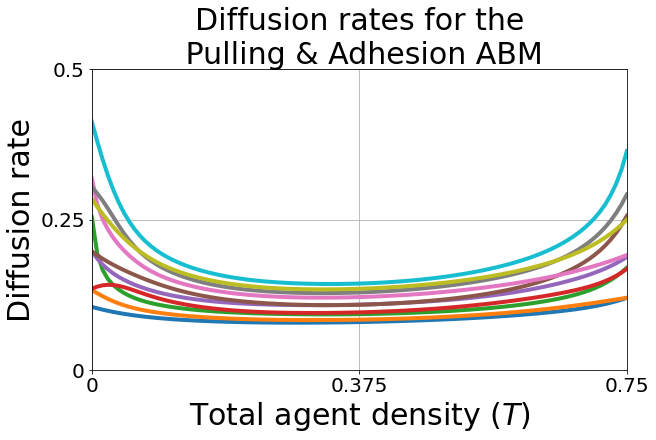

In [3]:
# create meshes
T_mesh = np.linspace(0, .75, 101)

fig, ax = initialize_param_plot()
###### plot
for binn, param_combo, color in zip(binns,params,colors_plot):
    
    rmh, rmp, Pp, Padh, Ppull, alpha = param_combo

    # evaluate parameter networks
    D_mesh = to_numpy(binn.diffusion(to_torch(T_mesh)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(T_mesh)[:, None]))

    ax.plot(T_mesh, D_mesh, '-', color=color,linewidth=4,markersize=10)

ax.set_xlim([0,0.75])
ax.set_ylim([0.0, 0.5])    
    
plt.title(f"Diffusion rates for the\n Pulling & Adhesion ABM",fontsize=fontsize)
plt.savefig(f'../../results/figures/learned_params_{scenario}.png')

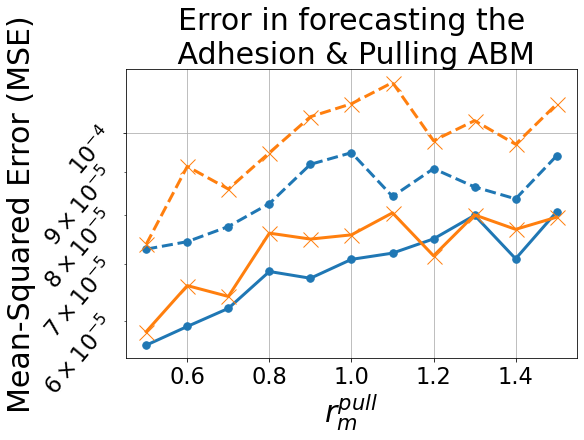

In [4]:
t_perc = 0.75

### Initialize lists storing the training and testing MSE values
MSE_binn_train = []
MSE_binn_test = []
MSE_MF_train = []
MSE_MF_test = []

for param_combo, param in zip(params, varying_params):
    
    rmh, rmp, Pp, Padh, Ppull, alpha = param_combo

    #Load in previously-computed BINN-guided PDE simulation & ABM data
    filename = f"../../results/PDE_sims/PDE_sim_DMLP_adhesion_pulling_mean_25_PmH_{rmh}_PmP_{rmp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}_pde_weight_{pde_weight}.npy"
    
    mat = np.load(filename, allow_pickle=True).item()
    #BINN-guided PDE simulations
    sol_binn = mat['U_sim']
    #ABM data
    U = mat['U_data']
    x = mat['x']
    t = mat['t']
    n = len(x)
    
    q = [rmh/4, rmp/4, Padh, Ppull]
    H0, P0 = alpha*U[:,0], (1-alpha)*U[:,0]
    IC = np.hstack( (H0, P0) )
    sol_T = DE_sim(x,t,q, IC, Heterogeneous_Diffusion_eqn,
                   PDE_type="two-compartment")
    
    tmax = np.max(t)
    sol_binn_train = sol_binn[:,t<=t_perc*tmax]
    sol_binn_test = sol_binn[:,t>t_perc*tmax]
    sol_MF_train = sol_T[:,t<=t_perc*tmax]
    sol_MF_test = sol_T[:,t>t_perc*tmax]
    U_train = U[:,t<=t_perc*tmax]
    U_test = U[:,t>t_perc*tmax]

    MSE_MF_train.append(MSE(sol_MF_train,U_train))
    MSE_MF_test.append(MSE(sol_MF_test,U_test))
    MSE_binn_train.append(MSE(sol_binn_train,U_train))
    MSE_binn_test.append(MSE(sol_binn_test,U_test))

#Convert to ndarray
MSE_MF_train = np.array(MSE_MF_train)
MSE_MF_test = np.array(MSE_MF_test)
MSE_binn_train = np.array(MSE_binn_train)
MSE_binn_test = np.array(MSE_binn_test)    
    
fig = plt.figure(figsize=(8,6),layout="constrained")
ax = fig.add_subplot(111)
    
plt.semilogy(varying_params, MSE_MF_train, ".-",label = "MF Model Training",markersize=15, linewidth=3, c = colors[0])
plt.semilogy(varying_params, MSE_MF_test, ".--",label = "MF Model Testing",markersize=15, linewidth=3, c = colors[0])
plt.semilogy(varying_params, MSE_binn_train, "x-",label = "BINN Model Training",markersize=15, linewidth=3, c = colors[1])
plt.semilogy(varying_params, MSE_binn_test, "x--",label = "BINN Model Testing",markersize=15, linewidth=3, c = colors[1])

ax.set_xlabel(suptitle,fontsize=fontsize)
ax.set_ylabel("Mean-Squared Error (MSE)",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=.75*fontsize)
ax.tick_params(axis='both', which='minor', labelsize=.75*fontsize)

ax.tick_params(axis='both', which='major', labelsize=.75*fontsize)
ax.tick_params(axis='both', which='minor', labelsize=.75*fontsize)
ax.tick_params(axis='y', which='major', rotation = 50)
ax.tick_params(axis='y', which='minor', rotation = 50)

plt.title("Error in forecasting the\n Adhesion & Pulling ABM",fontsize=fontsize)

plt.grid()

plt.savefig(f"../../results/figures/Adhesion_Pulling_error_analysis_{scenario}.png",format="png")